# Quickly show that we can do things!

This notebook is just to demonstrate that notebooks can be run in docker containers.

In the toolbar, click "Cell" and select the "Run All" option in the dropdown menu.
Then scroll down to have a look at some nice plots!

In [1]:
# Import our libraries.
# Things would fail here if we hadn't set up docker properly.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [2]:
%matplotlib inline

In [3]:
# Load an example dataset.
iris = datasets.load_iris()

# We won't actually use this dataframe, it's just to see what the data look like.
iris_df = pd.DataFrame(
    data=iris.data,
    index=pd.Series(iris.target_names[iris.target], name="species"),
    columns=iris.feature_names,
)

iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
species,,,,
setosa,5.1,3.5,1.4,0.2
setosa,4.9,3.0,1.4,0.2
setosa,4.7,3.2,1.3,0.2
setosa,4.6,3.1,1.5,0.2
setosa,5.0,3.6,1.4,0.2


In [4]:
# Perform some simpler machine learning tasks.

# Predict the species of the iris based on sepal and petal features.
model = LogisticRegression(solver="lbfgs", multi_class="auto", max_iter=200, C=0.1)
model.fit(iris.data, iris.target)

# Run PCA on the data so we can plot in 3 dimensions instead of 4.
predicted = model.predict(iris.data)
X_reduced = PCA(n_components=3).fit_transform(iris.data)

In [5]:
# Define some functions to help plot things.

def np_groupby(arr, groups):
    for i in np.unique(groups):
        yield arr[groups == i]


def iter_groups(names, arr, groups, colours=plt.cm.Set1.colors):
    grouped_arr = np_groupby(arr, groups)
    return zip(names, grouped_arr, colours)


def add_scatter_3d(ax, label, arr, colour):
    ax.scatter(
        arr[:, 0],
        arr[:, 1],
        arr[:, 2],
        c=[colour],
        edgecolor='k',
        s=40,
        depthshade=False,
        label=label,
    )
    return


def plot_scatter_3d(data, labels, actual, predicted):
    # set up a figure twice as wide as it is tall
    fig = plt.figure(figsize=plt.figaspect(0.5))

    # set up the axes
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')

    # Plot the data
    # Left
    ax1.set_title("Actual labels")
    for label, arr, colour in iter_groups(labels, data, actual):
        add_scatter_3d(ax1, label, arr, colour)

    # Right
    ax2.set_title("Predicted labels")
    for label, arr, colour in iter_groups(labels, data, predicted):
        add_scatter_3d(ax2, label, arr, colour)

    # Remove the axis ticks
    for ax in [ax1, ax2]:
        ax.w_xaxis.set_ticklabels([])
        ax.w_yaxis.set_ticklabels([])
        ax.w_zaxis.set_ticklabels([])

    # Add a legend
    legend = ax2.legend(bbox_to_anchor=[1.1, 1])
    legend.get_frame().set_edgecolor("1.0")

    fig.tight_layout()
    return fig, (ax1, ax2)

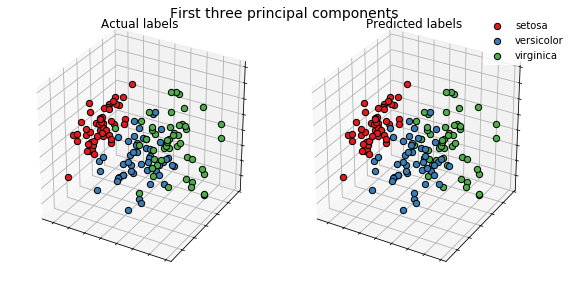

In [6]:
# Plot the darn thing.

fig, _ = plot_scatter_3d(X_reduced, iris.target_names, iris.target, predicted)
fig.suptitle("First three principal components", fontsize=14)
plt.show()

You can see that the penalised logistic regression model gets a couple of the predictions wrong.
But more importantly, we were able to run everything in a reproducible way.


# (Optional) Interactive plots!

Just for kicks :)

In [7]:
import plotly.plotly as py
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [8]:
init_notebook_mode(connected=True)

In [9]:
def iter_groups_with_preds(names, arr, groups, preds, colours=plt.cm.Set1.colors):
    grouped_arr = np_groupby(arr, groups)
    grouped_preds = np_groupby(preds, groups)
    return zip(names, grouped_arr, grouped_preds, colours)

In [10]:
data = []

for label, arr, preds, colour in iter_groups_with_preds(
        iris.target_names,
        X_reduced,
        iris.target,
        predicted
):
    trace = go.Scatter3d(
        x=arr[:, 0],
        y=arr[:, 1],
        z=arr[:, 2],
        text=["actual: {}</br>predicted: {}".format(label, iris.target_names[p]) for p in preds],
        name=label,
        mode='markers',
        marker=dict(
            size=6,
            line=dict(
                color=colour,
                width=0.5
            ),
            opacity=0.7
        )
    )
    data.append(trace)


layout = go.Layout(
    title=dict(
        text="First 3 principal components"
    ),
    margin=dict(
        l=10,
        r=20,
        b=10,
        t=30,
    ),
    scene=dict(
        xaxis=dict(
            title='PC1',
            zerolinewidth=1,
        ),
        yaxis=dict(
            title='PC2',
            zerolinewidth=1,
        ),
        zaxis=dict(
            title='PC3',
            zerolinewidth=1,
        ),
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='simple-3d-scatter')